### Adaptive_threshold

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix
import os
import pandas as pd
import re
from sklearn.model_selection import ParameterGrid

In [9]:
def plot_image(image):
    plt.imshow(image, cmap='gray')
    plt.show()

In [44]:
imagen1 = cv2.imread('database/18.pgm', cv2.IMREAD_UNCHANGED)

In [45]:
imagenres = cv2.imread('database/18_gt.pgm', cv2.IMREAD_UNCHANGED)

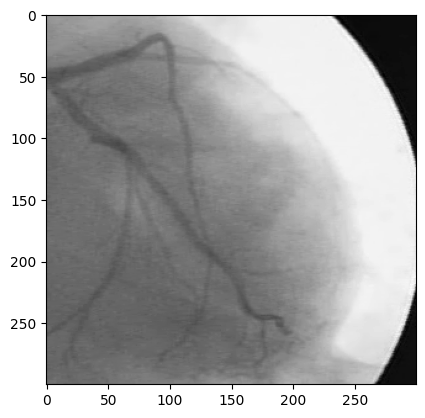

In [46]:
plot_image(imagen1)

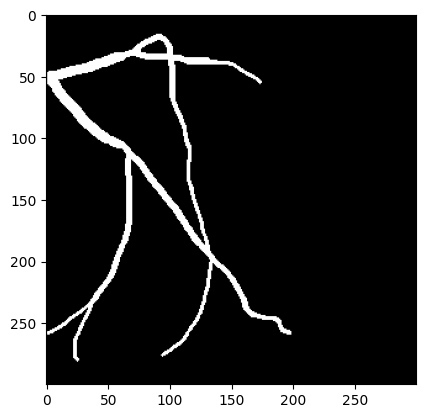

In [47]:
plot_image(imagenres)

In [5]:
def mostrar_rango(imagen_gris):
    valor_minimo = np.min(imagen_gris)
    valor_maximo = np.max(imagen_gris)
    
    plt.imshow(imagen_gris, cmap='gray')
    plt.title('Imagen en Escala de Grises')
    cbar = plt.colorbar(ticks=[valor_minimo, valor_maximo], orientation='vertical')
    cbar.set_label('Niveles de Gris', rotation=270, labelpad=15)
    plt.show()

In [6]:
def mostrar_histograma(imagen_gris):
    hist, bins = np.histogram(imagen_gris.flatten(), bins=256, range=(0,256))
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()

    plt.plot(cdf_normalized, color='b')
    plt.hist(imagen_gris.flatten(), bins=256, range=(0,256), color='gray', alpha=0.7)
    plt.title('Histograma de la Imagen en Escala de Grises')
    plt.xlabel('Niveles de Gris')
    plt.ylabel('Frecuencia')
    plt.show()

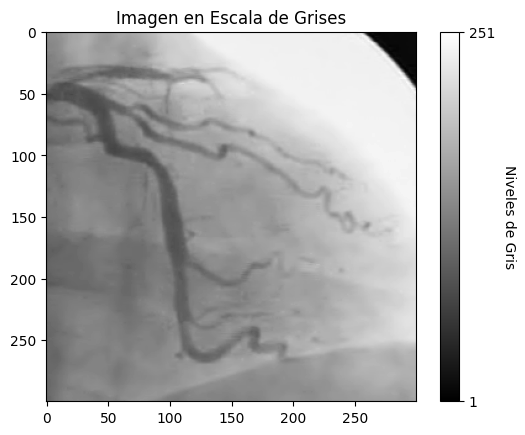

In [7]:
mostrar_rango(imagen1)

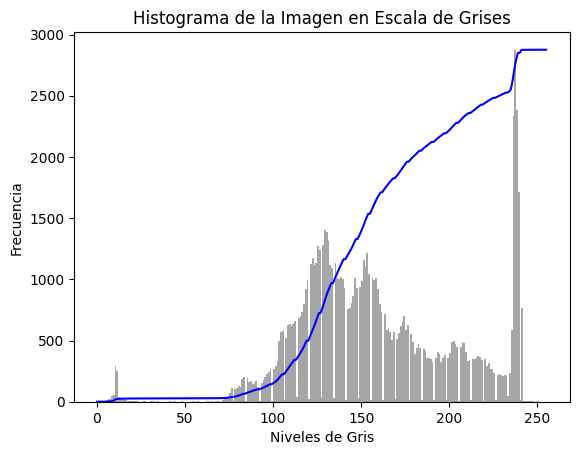

In [8]:
mostrar_histograma(imagen1)

In [41]:
def adaptive_threshold(image, block_size, c):
    # Obtener dimensiones de la imagen
    height, width = image.shape
    
    # Crear una matriz para la imagen binarizada
    binary_image = np.ones_like(image, dtype=np.uint8) * 255  # Inicializar con blanco
    
    # Iterar sobre cada píxel de la imagen
    for y in range(0, height):
        for x in range(0, width):
            # Definir límites del bloque
            x_min = max(0, x - (block_size // 2))
            x_max = min(width, x + (block_size // 2))
            y_min = max(0, y - (block_size // 2))
            y_max = min(height, y + (block_size // 2))
            
            # Calcular el umbral local como la media de los valores de los píxeles en el bloque
            block_mean = np.mean(image[y_min:y_max, x_min:x_max])
            
            # Aplicar el umbral
            if image[y, x] > block_mean - c:
                binary_image[y, x] = 0  # Cambiar a negro
    
    return binary_image

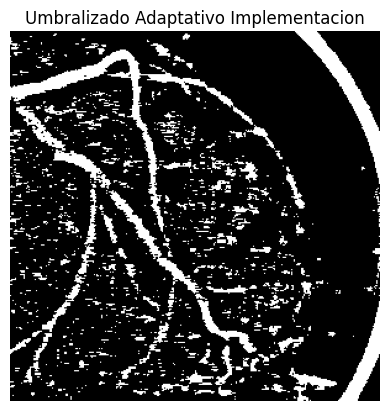

In [68]:
block_size = 21
c = 4
binary_image = adaptive_threshold(imagen1, block_size, c)

# Mostrar la imagen binarizada
plt.imshow(binary_image, cmap='gray')
plt.title('Umbralizado Adaptativo Implementacion')
plt.axis('off')
plt.show()

In [37]:
def calculate_metrics(binary_image, image_res):
    binary_image_flat = binary_image.flatten()
    image_res_flat = image_res.flatten()

    accuracy = accuracy_score(image_res_flat, binary_image_flat)
    precision = precision_score(image_res_flat, binary_image_flat,pos_label=255)
    recall = recall_score(image_res_flat, binary_image_flat, pos_label=255)
    f1 = f1_score(image_res_flat, binary_image_flat, pos_label=255)

    tn, fp, fn, tp = confusion_matrix(image_res_flat, binary_image_flat).ravel()
    specificity = tn / (tn + fp)

    return accuracy, recall, specificity, precision, f1


In [38]:
calculate_metrics(binary_image,imagenres)

(0.9520888888888889,
 0.8886626996554964,
 0.95693304948932,
 0.6117938766709788,
 0.7246839484101647)

In [81]:
def find_best_parameters(image_path, gt_image_path):
    best_recall = 0
    best_f1_score = 0
    best_parameters = {}

    # Cargar imágenes
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    gt_image = cv2.imread(gt_image_path, cv2.IMREAD_UNCHANGED)

    # Rango de parámetros para probar
    block_sizes = [15, 21, 31]
    cs = [5, 10, 15]

    for block_size in block_sizes:
        for c in cs:
            # Aplicar umbral adaptativo
            binary_image = adaptive_threshold(image, block_size, c)

            # Calcular métricas
            binary_image_flat = binary_image.flatten()
            gt_image_flat = gt_image.flatten()
            recall = recall_score(gt_image_flat, binary_image_flat,pos_label=255)
            f1 = f1_score(gt_image_flat, binary_image_flat, pos_label=255)
            # Actualizar los mejores parámetros si es necesario
            if recall > best_recall or (recall == best_recall and f1 > best_f1_score):
                best_recall = recall
                best_f1_score = f1
                best_parameters = {'block_size': block_size, 'c': c}

    return best_parameters, best_recall, best_f1_score


In [85]:
def process_images(database_path,block_size,c):
    results = []
    patron = re.compile(r'(\d+)_gt\.pgm')
    for archivo in os.listdir(database_path):
        if patron.match(archivo):
            numero = int(patron.match(archivo).group(1))
            
            # Forma los nombres de los archivos correspondientes
            archivo_gt = f"{numero}_gt.pgm"
            archivo_normal = f"{numero}.pgm"
            
            # Lee los archivos
            ruta_gt = os.path.join(database_path, archivo_gt)
            ruta_normal = os.path.join(database_path, archivo_normal)


            imagen_oper = cv2.imread(ruta_normal, cv2.IMREAD_UNCHANGED)
            imagenres = cv2.imread(ruta_gt, cv2.IMREAD_UNCHANGED)
            
            binary_image = adaptive_threshold(imagen_oper, block_size, c)
            
        
            accuracy, recall, specificity,precision, f1 = calculate_metrics(binary_image, imagenres)

            # Guardar los resultados en una lista
            results.append({
                'Image': numero,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'Specificity': specificity
            })

    results_df = pd.DataFrame(results)
    return results_df

In [86]:
def process_images_2(database_path):
    results = []
    patron = re.compile(r'(\d+)_gt\.pgm')
    for archivo in os.listdir(database_path):
        if patron.match(archivo):
            numero = int(patron.match(archivo).group(1))
            
            # Forma los nombres de los archivos correspondientes
            archivo_gt = f"{numero}_gt.pgm"
            archivo_normal = f"{numero}.pgm"
            
            # Lee los archivos
            ruta_gt = os.path.join(database_path, archivo_gt)
            ruta_normal = os.path.join(database_path, archivo_normal)


            imagen_oper = cv2.imread(ruta_normal, cv2.IMREAD_UNCHANGED)
            imagenres = cv2.imread(ruta_gt, cv2.IMREAD_UNCHANGED)

            best_params, best_recall, best_f1_score = find_best_parameters(ruta_normal, ruta_gt)
            
            binary_image = adaptive_threshold(imagen_oper, best_params["block_size"], best_params["c"])
            

            accuracy, recall, specificity,precision, f1 = calculate_metrics(binary_image, imagenres)

            # Guardar los resultados en una lista
            results.append({
                'Image': numero,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'Specificity': specificity
            })

    results_df = pd.DataFrame(results)
    return results_df
    

In [80]:
database_path = "database"


# Procesar las imágenes y guardar los resultados en un DataFrame
results_df = process_images_2(database_path)

# Mostrar el DataFrame con los resultados
print(results_df)

    Image  Accuracy  Precision    Recall  F1 Score  Specificity
0      10  0.903878   0.294969  0.856890  0.438866     0.906034
1      11  0.852856   0.199774  0.870800  0.324991     0.852095
2      12  0.904322   0.449414  0.919680  0.603782     0.903000
3      13  0.867478   0.221190  0.924860  0.357000     0.865101
4      14  0.904278   0.419398  0.875427  0.567107     0.906504
5      15  0.926222   0.394434  0.940231  0.555734     0.925499
6      16  0.841956   0.250983  0.937462  0.395957     0.836370
7      17  0.901622   0.309010  0.854820  0.453929     0.903973
8      18  0.878300   0.272819  0.815110  0.408809     0.881740
9      19  0.934000   0.401118  0.860225  0.547118     0.937585
10      1  0.884467   0.254799  0.909283  0.398055     0.883378
11     20  0.886900   0.381105  0.951926  0.544299     0.881934
12      2  0.881478   0.274503  0.919727  0.422813     0.879583
13      3  0.891011   0.268910  0.933617  0.417552     0.889150
14      4  0.900378   0.271587  0.745788

In [87]:
database_path = "database"
block_size = 31
c = 10

# Procesar las imágenes y guardar los resultados en un DataFrame
results_df = process_images(database_path, block_size, c)

# Mostrar el DataFrame con los resultados
print(results_df)

    Image  Accuracy  Precision    Recall  F1 Score  Specificity
0      10  0.927089   0.323044  0.604357  0.421034     0.941896
1      11  0.925444   0.303721  0.644359  0.412846     0.937363
2      12  0.943789   0.609916  0.806981  0.694744     0.955567
3      13  0.952544   0.448883  0.847486  0.586904     0.956897
4      14  0.949378   0.648305  0.640863  0.644562     0.973179
5      15  0.955811   0.531021  0.852615  0.654444     0.961137
6      16  0.947356   0.513868  0.875528  0.647628     0.951557
7      17  0.934422   0.374745  0.554936  0.447378     0.953486
8      18  0.930378   0.378195  0.541326  0.445290     0.951555
9      19  0.972178   0.718365  0.657396  0.686530     0.987475
10      1  0.950978   0.448168  0.721502  0.552898     0.961041
11     20  0.952089   0.611794  0.888663  0.724684     0.956933
12      2  0.946356   0.460523  0.796375  0.583578     0.953785
13      3  0.960400   0.517032  0.814126  0.632426     0.966788
14      4  0.959422   0.545762  0.487302

In [77]:
image_path = 'database/20.pgm'
gt_image_path = 'database/20_gt.pgm'

# Encontrar los mejores parámetros
best_params, best_recall, best_f1_score = find_best_parameters(image_path, gt_image_path)
print("Mejores parámetros:", best_params)
print("Mejor recall:", best_recall)
print("Mejor F1-score:", best_f1_score)
print(best_params['block_size'])

Mejores parámetros: {'block_size': 31, 'c': 5}
Mejor recall: 0.951926088318196
Mejor F1-score: 0.5442986972288132
31
